# Мобильные приложения — Выделение групп пользователей на основе поведения

Исследование поведения пользователей мобильного приложения "Ненужные вещи", в котором пользователи продают свои вещи, размещая их на доске объявлений

# Содержание

1. [Этап 1 - Загрузка и проверка данных](#stage_1)

  * [Загрузка данных](#stage_1_load)
  * [Проверка данных](#stage_1_check)
  * [Вывод ](#stage_1_summary)
  
  
2. [Этап 2 - Исследовательский анализ данных](#stage_2)

  * [Весь датафрейм](#stage_2_all)
  * [В разрезе источников](#stage_2_per_source)
  * [Вывод ](#stage_2_summary)
  
  
3. [Этап 3 - Сегментация пользователей](#stage_3)

  * [Вывод ](#stage_3_summary)
  
  
4. [Этап 4 - Проверка статистических гипотез](#stage_4)

  * [Вывод ](#stage_4_summary)
  
  
5. [Общий вывод](#conclusion)

Импорт необходимых для анализа библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

# Этап 1 - Загрузка и проверка данных<a id="stage_1"></a>

## Загрузка данных<a id="stage_1_load"></a>

Загрузим предоставленные данные в датафреймы

`actions` - сведения о действиях пользователей 

`sources` - источники из которых пользователи установили приложение

In [2]:
actions = pd.read_csv('datasets/mobile_dataset.csv')
sources = pd.read_csv('datasets/mobile_soures.csv')

#### actions

Отобразим датафрейм

In [3]:
actions

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
...,...,...,...
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9


Выведем общую информацию о нем

In [4]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Датафрейм содержит следующие колонки:

* event.time — время совершения события
* event.name — название события:
  * advert_open — открытие карточки объявления
  * photos_show — просмотр фотографий в объявлении
  * tips_show — пользователь увидел рекомендованные объявления
  * tips_click — пользователь кликнул по рекомендованному объявлению
  * contacts_show и show_contacts — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
  * contacts_call — пользователь позвонил по номеру телефона на карточке объявления
  * map — пользователь открыл карту размещенных объявлений
  * search_1 — search_7 — разные события, связанные с поиском по сайту
  * favorites_add — добавление объявления в избранное

* user.id — идентификатор пользователя совершившего событие

В колонке `event.time` требуется изменить тип данных на временной

Изменим наименования колонок для удобства

In [5]:
actions.columns = ['event_time', 'event_name', 'userid']

Переведем значения в столбце `event_time` во временные

In [6]:
actions['event_time'] = pd.to_datetime(actions['event_time'])

#### sources

Отобразим датафрейм и общую информацию о нем

In [7]:
sources

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google
...,...,...
4288,b86fe56e-f2de-4f8a-b192-cd89a37ecd41,yandex
4289,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,yandex
4290,437a4cd4-9ba9-457f-8614-d142bc48fbeb,yandex
4291,c10055f0-0b47-477a-869e-d391b31fdf8f,yandex


In [8]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Датафрейм содерижит две колонки:

* userId — идентификатор пользователя
* source — источник, из которого пользователь установил приложение

Преобразований типов не требуется

Переведем названия столбцов в нижний регистр

In [9]:
sources.columns = sources.columns.str.lower()
sources.columns

Index(['userid', 'source'], dtype='object')

## Проверка данных<a id="stage_1_check"></a>

Проверим уникальные значения в столбце `event_name`

In [10]:
actions['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Так как записи show_contacts и contacts_show обозначают одно событие - заменим их на одну запись

In [11]:
actions['event_name'] = actions['event_name'].replace('show_contacts', 'contacts_show')

Мы не имеем сведений о том, как различаются между собой события поиска, поэтому заменим их на одно обозначение

In [12]:
searches = ['search_1','search_2','search_3','search_4','search_5','search_6','search_7']

In [13]:
actions['event_name'] = actions['event_name'].replace(searches, 'search')

Проверим таблицы на дубли

In [14]:
actions.duplicated().sum()

0

In [15]:
sources.duplicated().sum()

0

Убедимся в том, что для каждого пользователя имеется запись только об одном источнике из которого он установил приложение

In [16]:
sources.pivot_table(index='userid', aggfunc='count')['source'].value_counts()

1    4293
Name: source, dtype: int64

Проверим для каждого ли пользователя есть источник откуда он установил приложение

In [17]:
actions['userid'].isin(sources['userid'].values).sum()

74197

Каждый пользователь в таблице `actions` имеет соответствие в таблице `source`

Проверим количество действий пользователей в секунду, так как в колонке `event_time` время содержится с точностью до наносекунды создадим еще один столбец в который запишем время обрезанное до секунды

In [18]:
actions['time_sec'] = actions['event_time'].astype('datetime64[s]')

Отобразим количество пользователей которые совершали в приложении больше чем одно действие в секунду

In [19]:
event_count = actions.pivot_table(index=['userid','time_sec'], values='event_name', aggfunc='count').reset_index().sort_values('event_name', ascending=False)
event_count[event_count['event_name'] > 1]['userid'].nunique()

450

Запишем `userid` этих пользователей в список

In [20]:
extr_users = event_count[event_count['event_name'] > 1]['userid']

Посчитаем все записи о более чем одном действии этих пользователей в секунду

In [21]:
event_count_extr_user = actions[actions['userid'].isin(extr_users)].pivot_table(index=['userid','time_sec', 'event_name'], values='event_time', aggfunc='count').reset_index().sort_values('event_time', ascending=False)
event_count_extr_user = event_count_extr_user[event_count_extr_user['event_time'] > 1]

Выведем на экран среднее количество действий в секунду в разрезе действий

In [22]:
event_count_extr_user.pivot_table(index='event_name', values='event_time', aggfunc='mean').round(2)

,event_time
event_name,
advert_open,2.00
contacts_call,2.17
contacts_show,2.10
favorites_add,2.50
map,2.33
photos_show,2.31
search,2.06
tips_click,2.00
tips_show,2.07


Эти показатели могут быть объяснены неточностью передачи информации от клиента к серверу, в целом подозрительной активности не наблюдается

## Вывод <a id="stage_1_summary"></a>

Мы загрузили предоставленные данные в датафреймы, переименовали столбцы и объединили записи о некоторых событиях


Далее мы проверили таблицы на дубли (их не оказалось), убедились в том что для каждого пользователя есть запись только об одном источнике откуда он установил приложене и то, что эти сведения есть для каждого пользователя

На последнем этапе мы провели анализ количества действий пользователей в секунду и пришли к выводу, что подозрительных действий в таблице нет

# Этап 2 - Исследовательский анализ данных<a id="stage_2"></a>

## Весь датафрейм<a id="stage_2_all"></a>

Количество записей

In [23]:
len(actions)

74197

Количество уникальных пользователей

In [24]:
actions['userid'].nunique()

4293

### Распределение по времени

Построим диаграмму распределения событий по времени

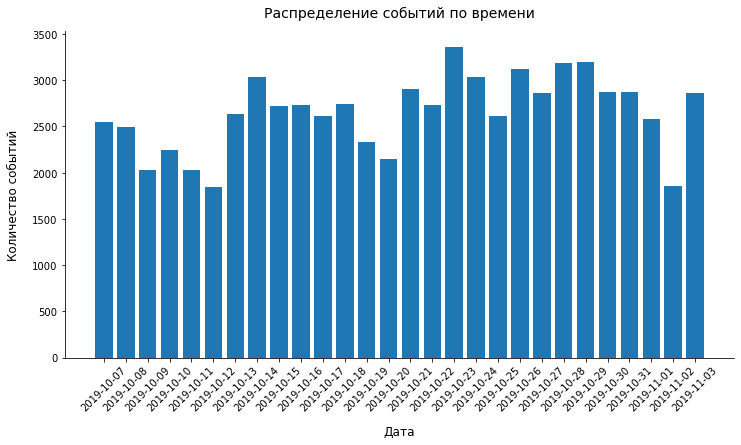

In [25]:
plt.figure(figsize=(12,6))
plt.bar(height=actions['event_time'].astype('datetime64[D]').value_counts().values,
        x=actions['event_time'].astype('datetime64[D]').value_counts().index)
plt.title('Распределение событий по времени', fontsize=14, pad=14)
plt.xlabel('Дата', fontsize=12, labelpad=12)
plt.ylabel('Количество событий', fontsize=12, labelpad=12)
plt.xticks(actions['event_time'].astype('datetime64[D]').value_counts().index, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.show()

Распределение по времени выглядит достаточно равномерным

### Доля пользователей посмотревших контакты

Для каждого пользователя отметим, совершал ли он за все время целевое действие - просмотр контактов

In [26]:
actions.loc[actions['userid'].isin(actions[actions['event_name'] == 'contacts_show']['userid']), 'has_contacts_show'] = True
actions['has_contacts_show'] = actions['has_contacts_show'].fillna(False)

Посчитаем количество таких пользователей

In [27]:
actions[actions['has_contacts_show'] == True]['userid'].nunique()

981

Посчитаем их долю среди всего количества

In [28]:
round(actions[actions['has_contacts_show'] == True]['userid'].nunique() / actions['userid'].nunique() * 100, 1)

22.9

Целевое действие совершили 22,9% пользователей

### Количество событий на пользователя

Сгруппируем таблицу по пользователям, рассчитаем количество действий для каждого из них и методом describe выведем основные статистические показатели

In [29]:
actions.pivot_table(index='userid', values='event_name', aggfunc='count')['event_name'].describe().round(2)

count    4293.00
mean       17.28
std        29.13
min         1.00
25%         5.00
50%         9.00
75%        17.00
max       478.00
Name: event_name, dtype: float64

В среднем на каждого пользователя приходится 17 действий, медиана составляет 9, это означает что этом распределении имеется большое количество выбросов

Построим диаграмму размаха этого распределения 

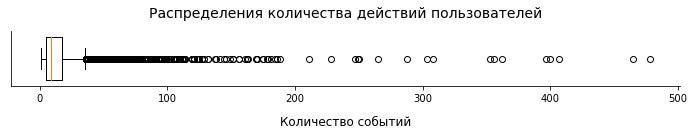

In [30]:
plt.figure(figsize=(12,1))
plt.boxplot(actions.pivot_table(index='userid', values='event_name', aggfunc='count')['event_name'], 
            vert=False, widths=0.8)
plt.title('Распределения количества действий пользователей', fontsize=14, pad=14)
plt.xlabel('Количество событий', fontsize=12, labelpad=12)
plt.ylabel(None)
plt.xticks(fontsize=10)
plt.yticks([])
sns.despine()
plt.show()

На диаграмме наблюдается большое количество выбросов, судя по открытым источникам с анализом подобной информации, это нормальная ситуация для пользователей мобильных приложений - всегда есть некоторое количество человек которые пользуются приложением аномально большое количество раз

Отобразим количество действий по перцентилям: 90%, 95%, 98% и 99%

In [31]:
np.percentile(actions.pivot_table(index='userid', values='event_time', aggfunc='count')['event_time'], [90,95,98,99])

array([ 36.  ,  59.  ,  95.16, 132.  ])

95% пользователей, записи о действиях которых находятся в нашем распоряжении, совершают в приложении 59 и меньше действий

### Время проведенное в приложении

Для того чтобы определить, сколько времени провел каждый пользователь в приложении для каждого его действия определим время предыдущего действия

In [32]:
actions['prev_event_time'] = actions.groupby('userid')['event_time'].shift()

Рассчитаем время, прошедшее между событиями

In [33]:
actions['time_between'] = actions['event_time'] - actions['prev_event_time']

Определимся с тем, что если между событиями прошло больше 30 минут - значит сессия была завершена и началась следующая.

Отметим окончания сессий в столбце `session_end`

In [34]:
actions.loc[(actions['time_between'] > pd.Timedelta(30, 'm')), 'session_end'] = 1
actions['session_end'] = actions['session_end'].fillna(0)

Отметим для каждого действия принадлежность к определенной сессии

In [35]:
actions['session_num'] = actions.groupby('userid', as_index=False)['session_end'].cumsum()

Рассчитаем длительность каждой сессии

In [36]:
session_lenght = actions.pivot_table(index=['userid','session_num'], values='event_time', aggfunc=['min','max']).reset_index()
session_lenght.columns = ['userid', 'session_num', 'session_start', 'session_end']
session_lenght['time_spent'] = session_lenght['session_end'] - session_lenght['session_start']
session_lenght.head()

,userid,session_num,session_start,session_end,time_spent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,00:09:55.727258
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1.0,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,00:08:27.385985
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2.0,2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028,00:14:59.272096
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3.0,2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203,00:12:38.171767
4,00157779-810c-4498-9e05-a1e9e3cedf93,0.0,2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098,00:25:20.787329


Рассчитаем количество сессий на пользователя и выведем основные статистические показатели о распределении

In [37]:
session_lenght.pivot_table(index='userid', values='session_num', aggfunc='count')['session_num'].describe(percentiles=[0.5]).round(2)

count    4293.00
mean        2.42
std         3.54
min         1.00
50%         1.00
max        99.00
Name: session_num, dtype: float64

В среднем на пользователя приходится 2,42 сессии в приложении, медианное значение 1. Максимальное количество сессий пришедшихся на одного пользователя - 99

Рассчитаем среднюю длительность сессии

In [38]:
session_lenght['time_spent'].describe(percentiles=[0.5])

count                     10368
mean     0 days 00:12:52.672627
std      0 days 00:19:51.611332
min             0 days 00:00:00
50%      0 days 00:05:35.169711
max      0 days 05:21:58.296302
Name: time_spent, dtype: object

В среднем длительность сессии составляет 13 минут, самая длительная сессия продолжалась больше 5 часов

Минимальная длительсть - 0 рассчитана для сессий которые состояли из одного действия

Теперь для каждого пользователя рассчитаем время проведенное в приложении

In [39]:
time_spent = session_lenght.pivot_table(index='userid', values='time_spent', aggfunc='sum').reset_index()
time_spent.head()

,userid,time_spent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,00:46:00.557106
1,00157779-810c-4498-9e05-a1e9e3cedf93,03:16:14.208630
2,00463033-5717-4bf1-91b4-09183923b9df,00:24:42.475025
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,01:50:44.358600
4,00551e79-152e-4441-9cf7-565d7eb04090,00:09:19.664543


In [40]:
time_spent['time_spent'].describe(percentiles=[0.5])

count                      4293
mean     0 days 00:31:06.077287
std      0 days 01:02:45.814535
min             0 days 00:00:00
50%      0 days 00:15:05.737061
max      1 days 04:04:45.608271
Name: time_spent, dtype: object

В среднем пользователи проводили в приложении по 30 минут, медианное значение в два раза меньше - 15 минут

### Retention rate

Для рассчета Retention rate нам необходимо разделить пользователей на когорты, так как в нашем распоряжении имеются данные за один месяц - когорты мы будем рассчитывать по неделям

Для каждого действия определеим номер недели когда оно было совершено

In [41]:
actions['event_week'] = actions['event_time'].dt.week

Каждому пользователю рассчитаем номер недели когда он совершил первое действие

In [42]:
first_week = actions.pivot_table(index='userid', values='event_week', aggfunc='min').reset_index()
first_week.columns = ['userid', 'first_week']
first_week.head()

,userid,first_week
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,41
1,00157779-810c-4498-9e05-a1e9e3cedf93,42
2,00463033-5717-4bf1-91b4-09183923b9df,44
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,42
4,00551e79-152e-4441-9cf7-565d7eb04090,43


Присоединим данные о номере недели первого появления каждого пользователя и рассчитаем неделю жизни когда это действие было совершено

In [43]:
actions = actions.merge(first_week, on='userid', how='left')
actions['lifetime'] = actions['event_week'] - actions['first_week']
actions.head()

,event_time,event_name,userid,time_sec,has_contacts_show,prev_event_time,time_between,session_end,session_num,event_week,first_week,lifetime
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:00,False,NaT,NaT,0.0,0.0,41,41,0
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:01,False,2019-10-07 00:00:00.431357,00:00:00.804963,0.0,0.0,41,41,0
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07 00:00:02,False,NaT,NaT,0.0,0.0,41,41,0
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:07,False,2019-10-07 00:00:01.236320,00:00:05.803014,0.0,0.0,41,41,0
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07 00:00:56,False,2019-10-07 00:00:02.245341,00:00:54.074472,0.0,0.0,41,41,0


Создадим когорты пользователей

In [44]:
cohorts = actions.pivot_table(index=['first_week', 'lifetime'], values='userid', aggfunc=pd.Series.nunique).reset_index()
cohorts.columns = ['first_week', 'lifetime', 'users']
cohorts.head()

,first_week,lifetime,users
0,41,0,1130
1,41,1,272
2,41,2,170
3,41,3,119
4,42,0,1166


К каждой когорте присоединим количество первоначальных пользователей

In [45]:
initial_users = cohorts[cohorts['lifetime'] == 0][['first_week','users']]
initial_users.columns = ['first_week', 'initial_users']
cohorts = cohorts.merge(initial_users, on='first_week', how='left')
cohorts.head()

,first_week,lifetime,users,initial_users
0,41,0,1130,1130
1,41,1,272,1130
2,41,2,170,1130
3,41,3,119,1130
4,42,0,1166,1166


Рассчитаем Retention rate каждой когорты на каждую неделю

In [46]:
cohorts['retention'] = cohorts['users'] / cohorts['initial_users']
cohorts.head()

,first_week,lifetime,users,initial_users,retention
0,41,0,1130,1130,1.000000
1,41,1,272,1130,0.240708
2,41,2,170,1130,0.150442
3,41,3,119,1130,0.105310
4,42,0,1166,1166,1.000000


Потроим тепловую карту

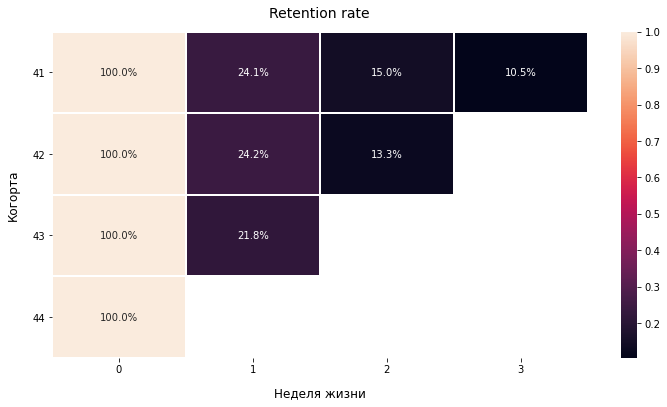

In [47]:
plt.figure(figsize=(12, 6))
sns.heatmap(cohorts.pivot_table(index='first_week', columns='lifetime', values='retention'), 
            annot=True, fmt='.1%', linewidths=1)
plt.title('Retention rate', fontsize=14, pad=14)
plt.ylabel('Когорта', fontsize=12, labelpad=12)
plt.xlabel('Неделя жизни', fontsize=12, labelpad=12)
plt.yticks(rotation=0)
plt.show()

Рассчитаем средний Retention rate по неделям

In [48]:
cohorts.pivot_table(index='lifetime', values='retention', aggfunc='mean').round(2)

,retention
lifetime,
0,1.00
1,0.23
2,0.14
3,0.11


Через неделю в приложение возвращается 23% пользователей, на третью неделю жизни этот показатель значительно снижается и составляет 14%, четвертая неделя - 11%, показатель ниже чем на предыдущей неделе, но незначительно, основная масса нелояльных пользователей отсекаются на третьей неделе

## В разрезе источников<a id="stage_2_per_source"></a>

Добавим сведения об источнике откуда пользователь установил приложение в таблицу `actions`

In [49]:
actions = actions.merge(sources, on='userid', how='left')

Рассчитаем количество пользователей из каждого источника

In [50]:
actions[['userid','source']].drop_duplicates()['source'].value_counts()

yandex    1934
other     1230
google    1129
Name: source, dtype: int64

Отобразим эти данные на диаграмме

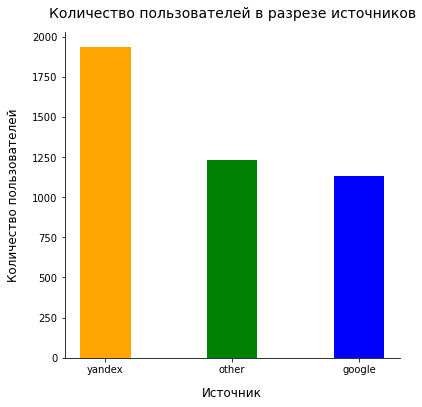

In [51]:
plt.figure(figsize=(6, 6))
plt.bar(height=actions[['userid','source']].drop_duplicates()['source'].value_counts().values,
        x=actions[['userid','source']].drop_duplicates()['source'].value_counts().index,
        width=0.4, color=['orange', 'green', 'blue'])
plt.title('Количество пользователей в разрезе источников', fontsize=14, pad=14)
plt.ylabel('Количество пользователей', fontsize=12, labelpad=12)
plt.xlabel('Источник', fontsize=12, labelpad=12)
sns.despine()
plt.show()

Больше всего пользователей установивших приложение из yandex - 1934, из google - 1129 пользователей и 1230 из всех остальных источников

### Доля пользователей посмотревших контакты

Отобразим доли пользователей посмотревших контакты в разрезе источников

In [52]:
for source in actions['source'].unique():
    has_contacts_show = actions[(actions['has_contacts_show'] == True) & (actions['source'] == source)]['userid'].nunique()
    total = actions[actions['source'] == source]['userid'].nunique()
    ratio = has_contacts_show / total
    print('Источник: {}\nвсего: {}, посмотрели контакты: {}, отношение: {:.1%}\n'.format(source, total, has_contacts_show, ratio))

Источник: other
всего: 1230, посмотрели контакты: 228, отношение: 18.5%

Источник: yandex
всего: 1934, посмотрели контакты: 478, отношение: 24.7%

Источник: google
всего: 1129, посмотрели контакты: 275, отношение: 24.4%



Доля пользователей, совершивших целевое действие для источников yandex и google различается совсем незначительно 24,7 и 24,4 процента

Для пользователей установивших приложение из других источников этот показатель составляет 18,5% и он ниже среднего значения для всех пользователей (22,9%)

### Количество событий на пользователя

Рассчитаем количество действий на каждого пользователя и присоединим к этой таблице информацию об источнике откуда пользователь установил приложение

In [53]:
actions_per_user = actions.pivot_table(index='userid', values='event_name', aggfunc='count').reset_index()
actions_per_user.columns = ['userid','event_count']
actions_per_user = actions_per_user.merge(sources, on='userid', how='left')

Выведем основные статистические показатели о количестве событий на пользователя в разрезе источников

In [54]:
actions_describe_concat = pd.Series(dtype='object')

for source in actions['source'].unique():
    actions_describe_source = actions_per_user[actions_per_user['source'] == source]['event_count'].describe(percentiles=[0.5])
    actions_describe_source.name = source
    actions_describe_concat = pd.concat([actions_describe_concat, actions_describe_source], axis=1, sort=False)
    
actions_describe_concat.drop(0, axis=1).round(2)

,other,yandex,google
count,1230.00,1934.00,1129.00
mean,15.83,17.73,18.11
std,22.81,30.83,32.09
min,1.00,1.00,1.00
50%,9.00,9.00,9.00
max,249.00,478.00,397.00


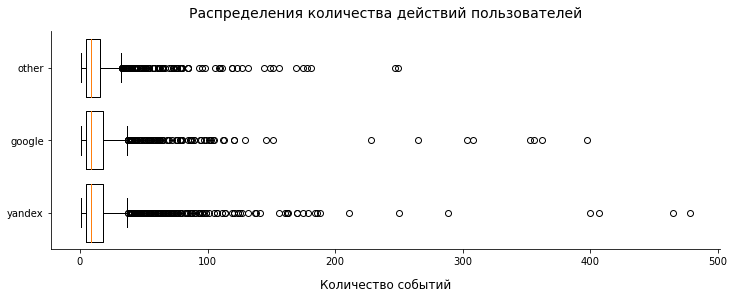

In [55]:
plt.figure(figsize=(12,4))
plt.boxplot(np.array([actions_per_user[actions_per_user['source'] == 'yandex']['event_count'],
                      actions_per_user[actions_per_user['source'] == 'google']['event_count'],
                      actions_per_user[actions_per_user['source'] == 'other']['event_count']], dtype='object'), 
            vert=False, widths=0.8, labels=['yandex','google','other'])
plt.title('Распределения количества действий пользователей', fontsize=14, pad=14)
plt.xlabel('Количество событий', fontsize=12, labelpad=12)
plt.xticks(fontsize=10)
sns.despine()
plt.show()

Количества действий пользователей в разрезе источников схожи, а медиана для всех трех категорий одинакова, выбросы по количеству действий на пользователя присутствуют в каждом источнике

### Время проведенное в приложении

К ранее составленной таблице со временем сессий добавим информацию об источнике

In [56]:
session_lenght = session_lenght.merge(sources, on='userid', how='left')

Рассчитаем среднее количество сессий на пользователя в разрезе источников и выведем информацию о распределениях

In [57]:
session_count_describe_concat = pd.Series(dtype='object')

for source in actions['source'].unique():
    session_count_describe = session_lenght[session_lenght['source'] == source].pivot_table(index='userid', values='session_num', aggfunc='count')['session_num'].describe(percentiles=[0.5])
    session_count_describe.name = source
    session_count_describe_concat = pd.concat([session_count_describe_concat, session_count_describe], axis=1, sort=False)
    
session_count_describe_concat.drop(0, axis=1).round(2)

,other,yandex,google
count,1230.00,1934.00,1129.00
mean,2.45,2.34,2.50
std,3.09,3.63,3.82
min,1.00,1.00,1.00
50%,1.00,1.00,1.00
max,45.00,99.00,52.00


Распределения количества сессий по источникам схожи, кроме максимального значения - для источника yandex оно составляет 99 сессий на одного из пользователей, что в два раза выше чем по остальным источникам

Добавим ранее расчитанную информацию о времени проведенном в приложении в основную таблицу

In [58]:
actions = actions.merge(time_spent, on='userid', how='left')

Рассчитаем и выведем основные статистические показатели

In [59]:
time_spent_per_source = actions[['userid','time_spent','source']].drop_duplicates()
time_describe_concat = pd.Series(dtype='object')

for source in time_spent_per_source['source'].unique():
    time_describe_source = time_spent_per_source[time_spent_per_source['source'] == source]['time_spent'].describe(percentiles=[0.5])
    time_describe_source.name = source
    time_describe_concat = pd.concat([time_describe_concat, time_describe_source], axis=1, sort=False)
    
time_describe_concat.drop(0, axis=1)

,other,yandex,google
count,1230,1934,1129
mean,0 days 00:26:42.044276,0 days 00:32:53.313123,0 days 00:32:50.033442
std,0 days 00:46:26.320700,0 days 01:07:23.459318,0 days 01:09:28.551567
min,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
50%,0 days 00:12:28.697246,0 days 00:16:11.904450,0 days 00:15:55.545123
max,0 days 09:06:39.438021,1 days 04:04:45.608271,0 days 19:07:25.528439


Аналогично предыдущим распределениям - средние значения схожи, максимальное выше у источника yandex (это обусловлено большим количеством пользователей)

### Retention rate

Определим функцию для разделения пользователей на когорты по источнику

In [60]:
def cohorts_retention(source):
    cohorts = actions[actions['source'] == source].pivot_table(index=['first_week', 'lifetime'], values='userid', 
                                                               aggfunc=pd.Series.nunique).reset_index()
    cohorts.columns = ['first_week', 'lifetime', 'users']
    initial_users = cohorts[cohorts['lifetime'] == 0][['first_week','users']]
    initial_users.columns = ['first_week', 'initial_users']
    cohorts = cohorts.merge(initial_users, on='first_week', how='left')
    cohorts['retention'] = cohorts['users'] / cohorts['initial_users']
    return cohorts

Построим тепловые карты Retention rate по каждому источнику

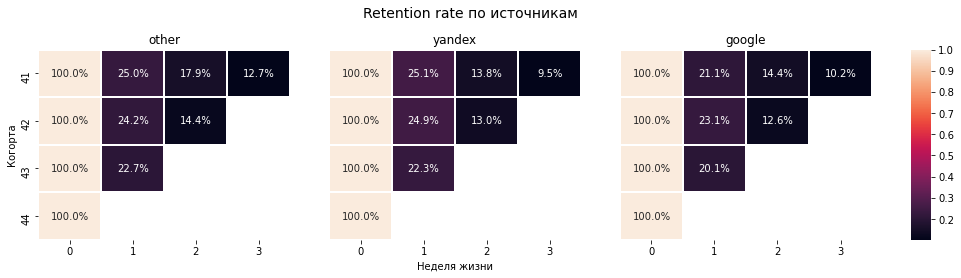

In [61]:
fig, axes = plt.subplots(1,4, figsize=(16,3.5), gridspec_kw={'width_ratios':[1,1,1,0.08]})

h1 = sns.heatmap(cohorts_retention('other').pivot_table(index='first_week', columns='lifetime', values='retention'), 
                 annot=True, fmt='.1%', linewidths=1, cbar=False, ax=axes[0])
h1.set_title('other')
h1.set_ylabel('Когорта')
h1.set_xlabel('')

h2 = sns.heatmap(cohorts_retention('yandex').pivot_table(index='first_week', columns='lifetime', values='retention'), 
                 annot=True, fmt='.1%', linewidths=1, cbar=False, ax=axes[1])
h2.set_title('yandex')
h2.set_ylabel('')
h2.set_xlabel('Неделя жизни')
h2.set_yticks([])

h3 = sns.heatmap(cohorts_retention('google').pivot_table(index='first_week', columns='lifetime', values='retention'), 
                 annot=True, fmt='.1%', linewidths=1, ax=axes[2], cbar_ax=axes[3])
h3.set_title('google')
h3.set_ylabel('')
h3.set_xlabel('')
h3.set_yticks([])

plt.suptitle('Retention rate по источникам', y=1.05, fontsize=14)
plt.show()

Retention rate по источникам между собой различается слабо

## Вывод <a id="stage_2_summary"></a>

**Все пользователи**

В нашем распоряжении имеется 74197 записей о действиях 4293 пользователей

События достаточно равномерно распределены по дням наблюдения, целевое действие (просмотр контактов) совершили 981 пользователей (22,9%)

В среднем на каждого пользователя приходится 17 действий, 95% пользователей, записи о действиях которых находятся в нашем распоряжении, совершают в приложении 59 и меньше действий. Но имеется большое количество выбросов, судя по открытым источникам с анализом подобной информации, это нормальная ситуация для пользователей мобильных приложений - всегда есть некоторое количество человек которые пользуются приложением аномально большое количество раз

После разделения действий пользователей на сессии мы смогли определить что в среднем на пользователя приходится 2,42 сессии в приложении. Максимальное количество сессий пришедшихся на одного пользователя - 99. В среднем длительность сессии составляет 13 минут, самая длительная сессия продолжалась больше 5 часовм, минимальная длительсть - 0 рассчитана для сессий которые состояли из одного действия

За все время наблюдей, пользователи, в среднем, проводили в приложении по 30 минут

Через неделю в приложение возвращается 23% пользователей, на третью неделю жизни этот показатель значительно снижается и составляет 14%, на четвертой неделе - 11%, основная масса нелояльных пользователей отсекаются на третьей неделе

**Пользователи в разрезе источников**

Больше всего пользователей установивших приложение из yandex - 1934, из google - 1129 и 1230 пользователей из всех остальных источников

Доля пользователей, совершивших целевое действие для источников yandex и google различается совсем незначительно 24,7 и 24,4 процента. Для пользователей установивших приложение из других источников этот показатель составляет 18,5%

Среднее количество действий пользователей в приложении в разрезе источников схожи, а медианное значение для всех трех категорий одинаково

Распределения количества сессий по источникам различаются не значительно, кроме максимального значения - для источника yandex оно составляет 99 сессий на одного из пользователей, что в два раза больше чем по остальным источникам

Распределения времени проведенного в приложении для всех трех источников похожи, за исключением того, что максимальное значение выше у источника yandex (это обусловлено большим количеством пользователей)

Retention rate по источникам между собой различается слабо

# Этап 3 - Сегментация пользователей<a id="stage_3"></a>

Рассчитаем количество действий на каждого пользователя

In [62]:
actions_per_user = actions.pivot_table(index=['userid', 'event_name'], values='event_time', aggfunc='count').reset_index()
actions_per_user.columns = ['userid', 'event_name', 'event_count']
actions_per_user.head()

,userid,event_name,event_count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,6
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,29
2,00157779-810c-4498-9e05-a1e9e3cedf93,advert_open,2
3,00157779-810c-4498-9e05-a1e9e3cedf93,contacts_call,5
4,00157779-810c-4498-9e05-a1e9e3cedf93,contacts_show,11


Добавим эти сведения в основную таблицу

In [63]:
actions = actions.merge(actions_per_user, on=['userid','event_name'], how='left')

Найдем средние значения количетсва уникальных действий на каждого пользователя

In [64]:
mean_actions = actions_per_user.groupby('event_name', as_index=False)['event_count'].mean().round()
mean_actions

,event_name,event_count
0,advert_open,8.0
1,contacts_call,3.0
2,contacts_show,5.0
3,favorites_add,4.0
4,map,3.0
5,photos_show,9.0
6,search,4.0
7,tips_click,3.0
8,tips_show,14.0


Подготовим таблицу для хранения целевых метрик:
* Количество пользователей
* Среднее время проведенное в приложении
* Среднее количество действий
* Факт просмотра контактов
* Доля пользователей посмотревших контакты
* Retention rate на вторую неделю жизни

In [65]:
metrics = pd.DataFrame(columns=['Количество пользователей', 'Среднее время', 
                                'Среднее количество действий', 'Посмотрели контакты', 
                                'Доля посмотревших контакты', 'Retention rate на вторую неделю'])

Определим функцию для рассчета Retention rate на вторую неделю

In [66]:
def retention(data):
    cohorts = data.pivot_table(index=['first_week', 'lifetime'], values='userid', aggfunc=pd.Series.nunique).reset_index()
    cohorts.columns = ['first_week', 'lifetime', 'users']
    initial_users = cohorts[cohorts['lifetime'] == 0][['first_week','users']]
    initial_users.columns = ['first_week', 'initial_users']
    cohorts = cohorts.merge(initial_users, on='first_week', how='left')
    cohorts['retention'] = cohorts['users'] / cohorts['initial_users']
    segment_retention = cohorts[cohorts['lifetime'] == 1]['retention'].mean()
    return segment_retention

И функцию рассчитывающую остальные метрики

In [67]:
def segment_metrics(segment, name):
    time_spent = segment['time_spent'].mean()
    event_count = round(segment['event_count'].mean(),2)
    total_users = segment['userid'].nunique()
    has_contacts_show = segment[segment['has_contacts_show'] == True]['userid'].nunique()
    has_contacts_show_ratio = round(has_contacts_show / total_users, 2)
    segment_retention = round(retention(segment), 2)
    segment_metrics = pd.Series([total_users, time_spent, event_count, 
                                 has_contacts_show, has_contacts_show_ratio, 
                                 segment_retention], index=metrics.columns)
    segment_metrics.name = name 
    return segment_metrics

Рассчитаем и запишем в таблицу метрики по пользователям совершавшим различные действия

#### Открытие карточки объявления

Пользователи которые открывали объявления **реже** среднего значения

In [68]:
advert_open_below_mean = actions_per_user[(actions_per_user['event_name'] == 'advert_open') & (actions_per_user['event_count'] < mean_actions[mean_actions['event_name'] == 'advert_open']['event_count'].values[0])]['userid']
metrics = metrics.append(segment_metrics(actions[actions['userid'].isin(advert_open_below_mean)], 'advert_open_below_mean'))
metrics.loc['advert_open_below_mean']

Количество пользователей                              539
Среднее время                      0 days 02:08:49.454341
Среднее количество действий                         38.69
Посмотрели контакты                                    82
Доля посмотревших контакты                           0.15
Retention rate на вторую неделю                      0.22
Name: advert_open_below_mean, dtype: object

Пользователи которые открывали объявления **чаще** среднего значения

In [69]:
advert_open_above_mean = actions_per_user[(actions_per_user['event_name'] == 'advert_open') & (actions_per_user['event_count'] >= mean_actions[mean_actions['event_name'] == 'advert_open']['event_count'].values[0])]['userid']
metrics = metrics.append(segment_metrics(actions[actions['userid'].isin(advert_open_above_mean)], 'advert_open_above_mean'))
metrics.loc['advert_open_above_mean']

Количество пользователей                              212
Среднее время                      0 days 03:21:50.504335
Среднее количество действий                         55.74
Посмотрели контакты                                    56
Доля посмотревших контакты                           0.26
Retention rate на вторую неделю                      0.43
Name: advert_open_above_mean, dtype: object

#### Добавление объявления в избранное

In [70]:
has_favorites_add = actions_per_user[(actions_per_user['event_name'] == 'favorites_add') & (actions_per_user['event_count'] > 0)]['userid']
metrics = metrics.append(segment_metrics(actions[actions['userid'].isin(has_favorites_add)], 'has_favorites_add'))
metrics.loc['has_favorites_add']

Количество пользователей                              351
Среднее время                      0 days 03:45:49.444977
Среднее количество действий                         58.16
Посмотрели контакты                                   136
Доля посмотревших контакты                           0.39
Retention rate на вторую неделю                      0.46
Name: has_favorites_add, dtype: object

#### Просмотр фотографий

In [71]:
has_photos_show = actions_per_user[(actions_per_user['event_name'] == 'photos_show') & (actions_per_user['event_count'] > 0)]['userid']
metrics = metrics.append(segment_metrics(actions[actions['userid'].isin(has_photos_show)], 'has_photos_show'))
metrics.loc['has_photos_show']

Количество пользователей                             1095
Среднее время                      0 days 01:34:51.149593
Среднее количество действий                         25.99
Посмотрели контакты                                   339
Доля посмотревших контакты                           0.31
Retention rate на вторую неделю                      0.34
Name: has_photos_show, dtype: object

#### Пользователи которые открывали рекомендованные объявления

In [72]:
has_tips_click = actions_per_user[(actions_per_user['event_name'] == 'tips_click') & (actions_per_user['event_count'] > 0)]['userid']
metrics = metrics.append(segment_metrics(actions[actions['userid'].isin(has_tips_click)], 'has_tips_click'))
metrics.loc['has_tips_click']

Количество пользователей                              322
Среднее время                      0 days 05:02:34.951543
Среднее количество действий                          75.1
Посмотрели контакты                                   100
Доля посмотревших контакты                           0.31
Retention rate на вторую неделю                      0.39
Name: has_tips_click, dtype: object

Пользователи которые открывали рекомендованные объявления **реже** чем остальные

In [73]:
tips_click_below_mean = actions_per_user[(actions_per_user['event_name'] == 'tips_click') & (actions_per_user['event_count'] < mean_actions[mean_actions['event_name'] == 'tips_click']['event_count'].values[0])]['userid']
metrics = metrics.append(segment_metrics(actions[actions['userid'].isin(tips_click_below_mean)], 'tips_click_below_mean'))
metrics.loc['tips_click_below_mean']

Количество пользователей                              231
Среднее время                      0 days 03:31:33.964369
Среднее количество действий                         65.87
Посмотрели контакты                                    60
Доля посмотревших контакты                           0.26
Retention rate на вторую неделю                      0.33
Name: tips_click_below_mean, dtype: object

Пользователи которые открывали рекомендованные объявления **чаще** чем остальные

In [74]:
tips_click_above_mean = actions_per_user[(actions_per_user['event_name'] == 'tips_click') & (actions_per_user['event_count'] >= mean_actions[mean_actions['event_name'] == 'tips_click']['event_count'].values[0])]['userid']
metrics = metrics.append(segment_metrics(actions[actions['userid'].isin(tips_click_above_mean)], 'tips_click_above_mean'))
metrics.loc['tips_click_above_mean']

Количество пользователей                               91
Среднее время                      0 days 07:03:05.731154
Среднее количество действий                         87.33
Посмотрели контакты                                    40
Доля посмотревших контакты                           0.44
Retention rate на вторую неделю                      0.53
Name: tips_click_above_mean, dtype: object

#### Пользователи которые открывали объявления после поиска

In [75]:
has_search = actions_per_user[(actions_per_user['event_name'] == 'search') & (actions_per_user['event_count'] > 0)]['userid']
has_advert_open = actions_per_user[(actions_per_user['event_name'] == 'advert_open') & (actions_per_user['event_count'] > 0)]['userid']

In [76]:
searh_and_advert = actions[actions['userid'].isin(has_advert_open) & actions['userid'].isin(has_search)]['userid'].unique()
metrics = metrics.append(segment_metrics(actions[actions['userid'].isin(searh_and_advert)], 'searh_and_advert'))
metrics.loc['searh_and_advert']

Количество пользователей                              339
Среднее время                      0 days 03:28:41.103223
Среднее количество действий                         54.65
Посмотрели контакты                                    79
Доля посмотревших контакты                           0.23
Retention rate на вторую неделю                      0.38
Name: searh_and_advert, dtype: object

#### Пользователи которые открывали объявления из карты объявлений

In [77]:
has_map = actions_per_user[(actions_per_user['event_name'] == 'map') & (actions_per_user['event_count'] > 0)]['userid']

In [78]:
map_and_advert = actions[actions['userid'].isin(has_advert_open) & actions['userid'].isin(has_map)]['userid'].unique()
metrics = metrics.append(segment_metrics(actions[actions['userid'].isin(map_and_advert)], 'map_and_advert'))
metrics.loc['map_and_advert']

Количество пользователей                              517
Среднее время                      0 days 03:06:23.844638
Среднее количество действий                         49.62
Посмотрели контакты                                    86
Доля посмотревших контакты                           0.17
Retention rate на вторую неделю                      0.26
Name: map_and_advert, dtype: object

#### Количество сессий

In [79]:
sessions_count = actions[['userid','session_num']].drop_duplicates().pivot_table(index='userid', values='session_num', aggfunc='count').reset_index()
sessions_count.loc[sessions_count['session_num'] > sessions_count['session_num'].mean(), 'sessions_above_mean'] = True
sessions_count['sessions_above_mean'] = sessions_count['sessions_above_mean'].fillna(False)
sessions_count.head()

,userid,session_num,sessions_above_mean
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,True
1,00157779-810c-4498-9e05-a1e9e3cedf93,6,True
2,00463033-5717-4bf1-91b4-09183923b9df,1,False
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6,True
4,00551e79-152e-4441-9cf7-565d7eb04090,3,True


Пользователи количество сессий которых **больше** среднего

In [80]:
metrics = metrics.append(segment_metrics(actions[actions['userid'].isin(sessions_count[sessions_count['sessions_above_mean'] == True]['userid'])], 'sessions_above_mean'))
metrics.loc['sessions_above_mean']

Количество пользователей                             1115
Среднее время                      0 days 03:25:12.239595
Среднее количество действий                         58.39
Посмотрели контакты                                   446
Доля посмотревших контакты                            0.4
Retention rate на вторую неделю                      0.63
Name: sessions_above_mean, dtype: object

Пользователи количество сессий которых **меньше** среднего

In [81]:
metrics = metrics.append(segment_metrics(actions[actions['userid'].isin(sessions_count[sessions_count['sessions_above_mean'] == False]['userid'])], 'sessions_below_mean'))
metrics.loc['sessions_below_mean']

Количество пользователей                             3178
Среднее время                      0 days 00:33:50.655797
Среднее количество действий                         15.05
Посмотрели контакты                                   535
Доля посмотревших контакты                           0.17
Retention rate на вторую неделю                      0.07
Name: sessions_below_mean, dtype: object

Выведем записанные метрики

In [82]:
metrics

,Количество пользователей,Среднее время,Среднее количество действий,Посмотрели контакты,Доля посмотревших контакты,Retention rate на вторую неделю
advert_open_below_mean,539,02:08:49.454341,38.69,82,0.15,0.22
advert_open_above_mean,212,03:21:50.504335,55.74,56,0.26,0.43
has_favorites_add,351,03:45:49.444977,58.16,136,0.39,0.46
has_photos_show,1095,01:34:51.149593,25.99,339,0.31,0.34
has_tips_click,322,05:02:34.951543,75.10,100,0.31,0.39
tips_click_below_mean,231,03:31:33.964369,65.87,60,0.26,0.33
tips_click_above_mean,91,07:03:05.731154,87.33,40,0.44,0.53
searh_and_advert,339,03:28:41.103223,54.65,79,0.23,0.38
map_and_advert,517,03:06:23.844638,49.62,86,0.17,0.26
sessions_above_mean,1115,03:25:12.239595,58.39,446,0.40,0.63


## Вывод <a id="stage_3_summary"></a>

Всего мы выделили 11 сегментов:

7 **"хороших"** - сегменты в которых доля пользователей, совершивших целевое действие, выше средней по всему датафрейму (22,9%)
* Пользователи которые чаще других открывали объявления

  212 человек, 26% из них посмотрели контакты и провели в приложении по 3 часа 21 минуту, на вторую неделю в приоложение вернулось 43%, среднее количетсво действий в приложении 56
  
  
* Пользователи которые добавляли товары в избранное

  351 пользователь, 39% из них совершили целевое действие и проводили в приложении по 3 часа 45 минут, на вторую неделю в приоложение вернулось 46% из них, количество действий 58
  
  
* Пользователи которые смотрели фотографии

  1095 пользователей (четверть от общего количества), 31% посмотрели контакты, и 34% пользователей вернулись в приложение, среднее количество дейсвий 26 - в два раза ниже чем в других "хороших" сегментах


* Три сегмента пользователей которые переходили по рекомендованным объявлениям:

  * пользователи у которых вообще есть такое действие: 322 человека, конверсия в целевое действие 31%
    
  * пользователи которые открывали рекомендованные объявления реже остальных: общее количество 231, конверсия 26%
    
  * пользователи которые открывали рекомендованные объявления чаще остальных: 91 пользователь, контакты открыли 44% из них
  
  Среднее время использования приложения значительно больше среднего чем в других "хороших" сегментах: 5, 3,5 и 7 часов, среднее количество действий так же значительно превышает этот показатель в других сегментах
  
  
* Пользователи которые пользовались приложением чаще других 

  всего таких пользователей 1115, в среднем они провели в приложении по 3 с половиной часа и совершили по 58 действий, конверсия в целевое действие составила 40%, retention rate в два раза выше среднего 63% пользователей вернулись на вторую неделю
  

2 **"средних"** сегмента - конверсия в целевое действие которых близка к средней по всему датафрейму

* Пользователи которые открывали объявления после поиска

  339 человек, конверсия в целевое действие 23%, retention rate (38%) - выше среднего по всему датафрейму, количество действий 79, временя проведенное в приложении 3,5 часа
  
  
* Пользователи которые открывали объявления после просмотра карты объявлений

  таких пользователей 463, 92 из них (20%) посмотрели контакты, среднее количетсво действий (92) немного выше чем в предыдущем сегменте, среднее время проведенное в приложении - 3 часа

  
2 **"плохих"** сегмента - конверсия в целевое действие которых ниже средней

* пользователи которые открывали объявления реже других: количество - 539, конверсия в целевое действие 15%, retention rate 22%
  
  
* Пользователи которые пользовались приложением реже других

  всего таких пользователей 3178 (3/4 от общего количества), они провели в приложении в среднем по 33 минут и совершили в среднем по 15 действий, конверсия в целевое действие составила 17% а retention rate всего 7%

# Этап 4 - Проверка статистических гипотез<a id="stage_4"></a>

Критерий значимости определим в 5%

In [83]:
alpha = 0.05

#### Гипотеза 1

Проверим гипотезу о том, что конверсия в целевое действие для пользователей установивших приложение из yandex равна конверсии пользователей установивших приложение из google

* Нулевая гипотеза - между конверсиями нет значимой разницы
* Альтернативная гипотеза - между конверсиями есть значимая разница

Проведем двусторонний статистический Z-тест коверсий

In [84]:
google_users_trials = actions[actions['source'] == 'google']['userid'].nunique()
yandex_users_trials = actions[actions['source'] == 'yandex']['userid'].nunique()
google_users_successes = actions[(actions['has_contacts_show'] == True) & (actions['source'] == 'google')]['userid'].nunique()
yandex_users_successes = actions[(actions['has_contacts_show'] == True) & (actions['source'] == 'yandex')]['userid'].nunique()

p_value = proportions_ztest([google_users_successes, yandex_users_successes], [google_users_trials, yandex_users_trials])[1]

print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу


Результаты статистического теста свидетельствуют о том что оснований считать конверсии пользователей из двух источников (24,7% для yandex и 24,4% для google) разными нет

#### Гипотеза 2

Проверим гипотезу о том, что пользователи открывают объявления после поиска чаще чем после просмотра карты объявлений

* Нулевая гипотеза - пользователи чаще открывают объявления после поиска (либо пропорции равны)
* Альтернативная гипотеза - пользователи чаще открывают объявления после просмотра карты объявлений

Проведем односторонний статистический Z-тест пропорций

In [85]:
search_trials = actions[actions['userid'].isin(has_search)]['userid'].nunique()
map_trials = actions[actions['userid'].isin(has_map)]['userid'].nunique()
search_and_advert_successes = actions[actions['userid'].isin(has_advert_open) & actions['userid'].isin(has_search)]['userid'].nunique()
map_and_advert_successes = actions[actions['userid'].isin(has_advert_open) & actions['userid'].isin(has_map)]['userid'].nunique()

p_value = proportions_ztest([search_and_advert_successes, map_and_advert_successes], [search_trials, map_trials], 
                            alternative='smaller')[1]

print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  1.3646054617233679e-21
Отвергаем нулевую гипотезу


По результатам статистического теста мы должны отвергуть нулевую гипотезу, а значит принимается альтернативная гипотеза - пользователи чаще открывают объявления после просмотра карты объявлений

## Вывод <a id="stage_4_summary"></a>

Мы проверяли две гипотезы:
1. конверсия в целевое действие для пользователей установивших приложение из yandex равна конверсии пользователей установивших приложение из google
2. пользователи открывают объявления после поиска чаще чем после просмотра карты объявлений

Для проверки гипотез мы использовали Z-тест и получили следующие результаты

1. Мы не смогли отвергуть первую гипотезу, разница конверсии в целевое действие между разными источниками статистически не значима
2. Вторую гипотезу мы отвергли, пользователи чаще открывают объявления после просмотра карты объявлений

# Общий вывод<a id="conclusion"></a>

На первом этапе мы загрузили предоставленные данные в датафреймы, переименовали столбцы и объединили записи о некоторых событиях. После проверили таблиц на дубли (их не оказалось), мы убедились в том, что для каждого пользователя есть запись только об одном источнике откуда он установил приложение и том, что эти сведения есть для каждого пользователя. Напоследок мы провели анализ количества действий пользователей в секунду и пришли к выводу, что подозрительных действий в таблице нет

Далее мы провели исследовательский анализ данных и пришли к следующим выводам:

В нашем распоряжении имеется **74197 записей о действиях 4293 пользователей**, которые достаточно равномерно распределены по дням наблюдения. **Целевое действие (просмотр контактов) совершили 981 пользователей (22,9%)**

В среднем на каждого пользователя приходится **17 действий**, 95% пользователей, записи о действиях которых находятся в нашем распоряжении, совершают в приложении 59 и меньше действий. После разделения действий пользователей по сессиям мы смогли определить что в среднем на пользователя приходится **2,42** сессии в приложении. В среднем длительность сессии составляет **13 минут**, самая длительная сессия продолжалась больше 5 часов. За все время наблюдений, пользователи, в среднем, проводили в приложении по **30 минут**

Анализ коэффициента удержания показал что **через неделю в приложение возвращается 23% пользователей**, на третью неделю жизни этот показатель значительно снижается и составляет 14%, на четвертой неделе - 11%

Анализ поведения пользователей в разрезе источников

После того как мы добавили в таблицу `actions` сведения об источнике откуда пользователь установил приложение из таблицы `sources` мы смогли провести исследовательский анализ в разрезе этих источников

Больше всего пользователей установивших приложение из **yandex - 1934**, из **google - 1129** и 1230 пользователей из всех остальных источников

Доля пользователей, совершивших целевое действие для источников yandex и google различается совсем незначительно **24,7 и 24,4 процента**. Для пользователей установивших приложение из других источников этот показатель составляет 18,5%

Среднее количество действий пользователей в приложении в разрезе источников схожи (15.83, 17.73, 18.11), а медианное значение для всех трех категорий одинаково. Распределения количества сессий по источникам различаются не значительно. Распределения времени проведенного в приложении для всех трех источников также похожи, за исключением того, что максимальное значение выше у источника yandex (это обусловлено большим количеством пользователей). Retention rate по источникам между собой различается слабо

После завершения исследовательского анализа данных мы сегментировали пользователей в зависимости от их поведения, всего мы выделили 11 сегментов, среди которых отметим **три самых лучших** (по доле конверсии в целевое действие):

1. Пользователи которые добавляли товары в избранное - если пользователя предложение заинтересовало и он добавил его в избранное вероятность того, что он посмотрит контакты продавца выше, всего таких пользователей 351, 39% из них совершили целевое действие и проводили в приложении по 3 часа 45 минут, на вторую неделю в приоложение вернулось 46% из них, среднее количество действий у них 58

2. Пользователи которые открывали рекомендованные объявления чаще остальных: 91 пользователь, контакты открыли 44% из них, среднее время использования приложения составило 7 часов, среднее количество действий - 88 что значительно превышает этот показатель в других сегментах

3. Пользователи количество сессий которых выше среднего: всего таких пользователей 1115 (четверть от общего количетсва), в среднем они провели в приложении по 3 с половиной часа и совершили по 58 действий, конверсия в целевое действие составила 40%, retention rate в два раза выше среднего - 63% пользователей вернулись на вторую неделю

и **два плохих сегмента** в которых конверсия в целевое действие ниже средней:

1. Пользователи которые открывали объявления реже чем среднего: количество - 539, конверсия в целевое действие 15%, retention rate 22%

2. Пользователи которые у которых количество сессий ниже чем среднее: всего их 3178 (3/4 от общего количества), они провели в приложении в среднем по 33 минут и совершили в среднем по 15 действий, конверсия в целевое действие составила 17% а retention rate всего 7%

После сегментации пользователей мы проверили **две гипотезы**:
1. Конверсия в целевое действие для пользователей установивших приложение из yandex равна конверсии пользователей установивших приложение из google
2. Пользователи открывают объявления после поиска чаще чем после просмотра карты объявлений

В результате проверки гипотез мы пришли к следующим выводам:

1. Мы не смогли отвергуть первую гипотезу, разница конверсии в целевое действие между разными источниками статистически не значима
2. Вторую гипотезу мы отвергли, пользователи чаще открывают объявления после просмотра карты объявлений